# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

data_dir = "./dataset/"

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "./dataset/"
image_dir = "./images/"


## Loading the data

**Note** `pd.read_excel` gave me an errow while reading the `xlsx` file so had to install `openpyxl` using `pip3 install openpyxl` and give `engine=openpyxl` as an extra arguement.

In [2]:
#!pip3 install openpyxl

In [5]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


In [6]:
print ("Original data shape:", df_orig.shape)

Original data shape: (14000, 24)


In [7]:
#information of the dataset
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 14000 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  14000 non-null  float64       
 2   CUST_AGE                 14000 non-null  int64         
 3   OPEN_ACCT_CT             14000 non-null  int64         
 4   WF_dvc_age               14000 non-null  int64         
 5   PWD_UPDT_TS              10875 non-null  object        
 6   CARR_NAME                11291 non-null  object        
 7   RGN_NAME                 11291 non-null  object        
 8   STATE_PRVNC_TXT          11291 non-null  object        
 9   ALERT_TRGR_CD            14000 non-null  object        
 10  DVC_TYPE_TXT             12239 non-null  object        
 11  AUTHC_PRIM_TYPE_CD       14000 non-null  object        
 12  AUTHC_SCNDRY_STAT_TXT    13926 n

In [8]:
# check the target classes
df_orig["FRAUD_NONFRAUD"].unique()

array(['Non-Fraud', 'Fraud'], dtype=object)

## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

In [114]:
df = df_train0.copy()

In [115]:
df.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
2413,487.93,3714.91,43,5,1037,NaN,NaN,NaN,NaN,MOBL,...,CO,5/0/2020 12:33:41,1988-01-11,4/13/2021 5:2:29,4/13/2021,SCHPMT,P2P_COMMIT,P2P,4/13/2021,Fraud
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,NaN,NaN,NaN,MOBL,...,TX,NaN,1987-04-05,4/29/2021 22:54:53,4/29/2021,SCHPMT,P2P_COMMIT,P2P,4/29/2021,Non-Fraud


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11200 entries, 2413 to 114
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 11200 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  11200 non-null  float64       
 2   CUST_AGE                 11200 non-null  int64         
 3   OPEN_ACCT_CT             11200 non-null  int64         
 4   WF_dvc_age               11200 non-null  int64         
 5   PWD_UPDT_TS              8684 non-null   object        
 6   CARR_NAME                9022 non-null   object        
 7   RGN_NAME                 9022 non-null   object        
 8   STATE_PRVNC_TXT          9022 non-null   object        
 9   ALERT_TRGR_CD            11200 non-null  object        
 10  DVC_TYPE_TXT             9805 non-null   object        
 11  AUTHC_PRIM_TYPE_CD       11200 non-null  object        
 12  AUTHC_SCNDRY_STAT_TXT    11140 

In [117]:
df.shape

(11200, 24)

In [118]:
# find numerical and categorical columns
nume_cols = list(df.select_dtypes(include="number").columns)
cate_cols = list(df.select_dtypes(exclude="number").columns)
cate_cols.remove('FRAUD_NONFRAUD')

In [119]:
print ("Numeric Columns:\n", nume_cols)
print ("")
print ("Categorical Columns:\n", cate_cols)

Numeric Columns:
 ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT', 'WF_dvc_age', 'CUST_ZIP']

Categorical Columns:
 ['PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT', 'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_STATE', 'PH_NUM_UPDT_TS', 'CUST_SINCE_DT', 'TRAN_TS', 'TRAN_DT', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTVY_DT']


In [120]:
df[nume_cols].head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,CUST_ZIP
2413,487.93,3714.91,43,5,1037,80234
1003,4.84,0.00,53,5,305,75232


In [121]:
nume_cols.remove('CUST_ZIP')
cate_cols.append('CUST_ZIP')

In [122]:
print ("Numeric Columns:\n", nume_cols)
print ("")
print ("Categorical Columns:\n", cate_cols)

Numeric Columns:
 ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT', 'WF_dvc_age']

Categorical Columns:
 ['PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT', 'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_STATE', 'PH_NUM_UPDT_TS', 'CUST_SINCE_DT', 'TRAN_TS', 'TRAN_DT', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTVY_DT', 'CUST_ZIP']


In [123]:
df[nume_cols].head(5)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age
2413,487.93,3714.91,43,5,1037
1003,4.84,0.00,53,5,305
8660,494.94,2525.50,70,9,583
6349,0.01,0.00,70,6,467
1860,488.36,4344.55,38,4,0


## Class Distribution

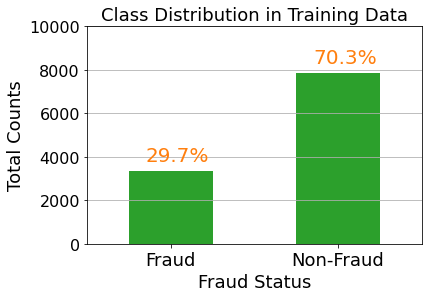

In [124]:
dfs=df.groupby("FRAUD_NONFRAUD")["CUST_ZIP"].count()
dfs.plot(kind='bar', color="C2")
plt.grid(axis='y')
plt.xticks(rotation=0, fontsize=18);
plt.xlabel("Fraud Status", fontsize=18);
plt.ylabel("Total Counts", fontsize=18);
plt.yticks( fontsize=16);
plt.title("Class Distribution in Training Data", fontsize=18);
pcts = np.round(100*dfs.values/df.shape[0], 1)
plt.text(0-0.15, 3800, str(pcts[0])+"%", fontsize=20, color="C1");
plt.text(1-0.15, 8300, str(pcts[1])+"%", fontsize=20, color="C1");
plt.ylim([0, 10000]);
plt.savefig("images/class_distribution.png", dpi=300, bbox_inches='tight')

## Handling missing variables

In [125]:
df.isnull().sum()

TRAN_AMT                      0
ACCT_PRE_TRAN_AVAIL_BAL       0
CUST_AGE                      0
OPEN_ACCT_CT                  0
WF_dvc_age                    0
PWD_UPDT_TS                2516
CARR_NAME                  2178
RGN_NAME                   2178
STATE_PRVNC_TXT            2178
ALERT_TRGR_CD                 0
DVC_TYPE_TXT               1395
AUTHC_PRIM_TYPE_CD            0
AUTHC_SCNDRY_STAT_TXT        60
CUST_ZIP                      0
CUST_STATE                   28
PH_NUM_UPDT_TS             5621
CUST_SINCE_DT                 0
TRAN_TS                       0
TRAN_DT                       0
ACTN_CD                       0
ACTN_INTNL_TXT                0
TRAN_TYPE_CD                  0
ACTVY_DT                      0
FRAUD_NONFRAUD                0
dtype: int64

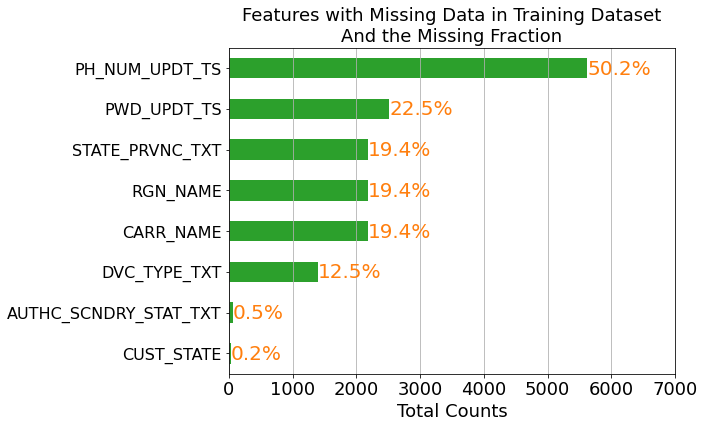

In [126]:
dfnull=df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=True)

dfnull.plot(kind='barh', color="C2", figsize=(8,6))
plt.grid(axis='x')
plt.yticks(rotation=0, fontsize=16);
#plt.ylabel("Features with Missing values", fontsize=18);
plt.xlabel("Total Counts", fontsize=18);
plt.xticks( fontsize=18);
plt.title("Features with Missing Data in Training Dataset\nAnd the Missing Fraction",
          fontsize=18);
pcts = np.round(100*dfnull.values/df.shape[0], 1)
vals = dfnull.values

for i in range(len(pcts)):
    plt.text(vals[i]*1, i-0.15, str(pcts[i])+"%", fontsize=20, color="C1");

plt.xlim([0, 7000]);
plt.savefig("images/fissing_data.png", dpi=300, bbox_inches='tight')


- From the above figure, we can see that 5 features: `PH_NUM_UPDT_TS`, `PWD_UPDT_TS`, `CARR_NAME`, `RGN_NAME`, `STATE_PRVNC_TXT` have almost one fifth of their total training data missing. Imputing these features is doable but the model might not be able to learn much from these features, so I believe dropping these features from the model is a good idea.

- There are 3 features: `DVC_TYPE_TXT`, `AUTHC_SCNDRY_STAT_TXT`, `CUST_STATE` which have less than one fifth missing data. In particular `AUTHC_SCNDRY_STAT_TXT`, `CUST_STATE` have less than 1 % of the missing data, which is completely normal in real world data. And we are going to impute the missing values in these three features.

- In order to impute the missing data we are using following two methods:
    - If the feature is `numerical`, we are going to impute the values by the `median` of the entire feature values.
    - If the feature is `categorical`, we are going to impute the values by the `mode` of the entire feature values.
    
## Case when real-world data has missing data in a new features

- This can totally happen when the model is deployed for production. To avoid our model from failing we have to make sure our code has a way to impute the missing data for any features that the model uses.

- Create a dictionary with all the column names as keys and the imputation value as the value.

In [127]:
impute_vals={}

for col in df.columns:
    if col in nume_cols:
        impute_vals[col] = df[col].median()
    elif col in cate_cols:
        impute_vals[col] = df[col].mode()[0]
        
impute_vals

{'TRAN_AMT': 162.07,
 'ACCT_PRE_TRAN_AVAIL_BAL': 2396.1549999999997,
 'CUST_AGE': 59.0,
 'OPEN_ACCT_CT': 5.0,
 'WF_dvc_age': 366.5,
 'PWD_UPDT_TS': '5/18/2020 4:7:20',
 'CARR_NAME': 'cox communications inc.',
 'RGN_NAME': 'southwest',
 'STATE_PRVNC_TXT': 'california',
 'ALERT_TRGR_CD': 'MOBL',
 'DVC_TYPE_TXT': 'MOBILE',
 'AUTHC_PRIM_TYPE_CD': 'UN_PWD',
 'AUTHC_SCNDRY_STAT_TXT': 'ALLOW',
 'CUST_ZIP': 77459,
 'CUST_STATE': 'CA',
 'PH_NUM_UPDT_TS': '7/8/2019 6:45:37',
 'CUST_SINCE_DT': Timestamp('1997-08-01 00:00:00'),
 'TRAN_TS': '2/3/2021 9:0:51',
 'TRAN_DT': '2/28/2021',
 'ACTN_CD': 'SCHPMT',
 'ACTN_INTNL_TXT': 'P2P_COMMIT',
 'TRAN_TYPE_CD': 'P2P',
 'ACTVY_DT': '2/28/2021'}

In [128]:
cols_to_drop = ['PH_NUM_UPDT_TS', 'PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT']
nume_cols    = [c for c in nume_cols if c not in cols_to_drop]
cate_cols    = [c for c in cate_cols if c not in cols_to_drop]

In [129]:
def impute_data(df, impute_dict=impute_vals):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [130]:
# impute the columns : cols_to_impute
df=impute_data(df)

In [131]:
df.isnull().sum()

TRAN_AMT                   0
ACCT_PRE_TRAN_AVAIL_BAL    0
CUST_AGE                   0
OPEN_ACCT_CT               0
WF_dvc_age                 0
PWD_UPDT_TS                0
CARR_NAME                  0
RGN_NAME                   0
STATE_PRVNC_TXT            0
ALERT_TRGR_CD              0
DVC_TYPE_TXT               0
AUTHC_PRIM_TYPE_CD         0
AUTHC_SCNDRY_STAT_TXT      0
CUST_ZIP                   0
CUST_STATE                 0
PH_NUM_UPDT_TS             0
CUST_SINCE_DT              0
TRAN_TS                    0
TRAN_DT                    0
ACTN_CD                    0
ACTN_INTNL_TXT             0
TRAN_TYPE_CD               0
ACTVY_DT                   0
FRAUD_NONFRAUD             0
dtype: int64

In [132]:
df.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
2413,487.93,3714.91,43,5,1037,5/18/2020 4:7:20,cox communications inc.,southwest,california,MOBL,...,CO,5/0/2020 12:33:41,1988-01-11,4/13/2021 5:2:29,4/13/2021,SCHPMT,P2P_COMMIT,P2P,4/13/2021,Fraud
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,cox communications inc.,southwest,california,MOBL,...,TX,7/8/2019 6:45:37,1987-04-05,4/29/2021 22:54:53,4/29/2021,SCHPMT,P2P_COMMIT,P2P,4/29/2021,Non-Fraud


In [133]:
df[nume_cols].head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age
2413,487.93,3714.91,43,5,1037
1003,4.84,0.00,53,5,305


In [146]:
def displot(df, xcol, xlabel, title, savename, xmax=None, bins=100):
    sns.displot(data=df,
            x=xcol,
            alpha=0.3,
            hue="FRAUD_NONFRAUD",
            height=4,
            aspect=3,
            kde=True,
            palette="bright", 
            bins=bins,
           )
    plt.yticks(rotation=0, fontsize=16);
    plt.ylabel("Count", fontsize=18);
    plt.xlabel(xlabel, fontsize=18);
    plt.xticks(fontsize=18);
    plt.title(title,fontsize=20);
    if xmax:
        plt.xlim([0, xmax]);
    plt.grid(axis='y')
    plt.savefig("images/"+savename+".png", dpi=300, bbox_inches='tight')


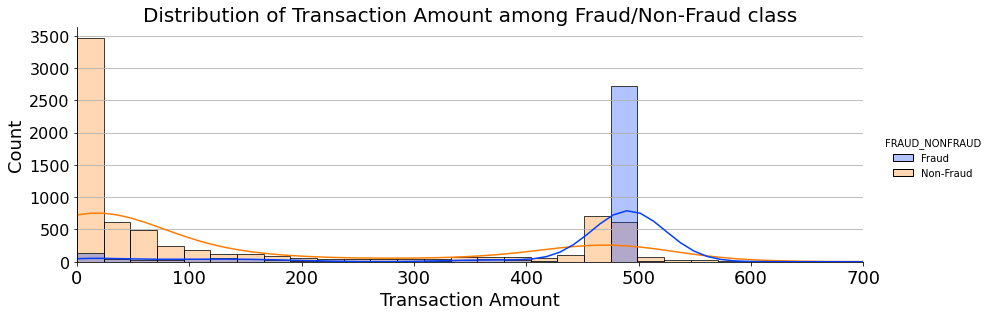

In [148]:
xcol="TRAN_AMT"
xlabel="Transaction Amount"
title="Distribution of Transaction Amount among Fraud/Non-Fraud class"
savename="dist_trans_amnt.png"
bins=100
xmax=700
displot(df, xcol, xlabel, title, savename, bins=bins, xmax=xmax)

- This plot shows that most of the Fraudulent transactions have been around $500.
- So this clearly is an important feature in the model.

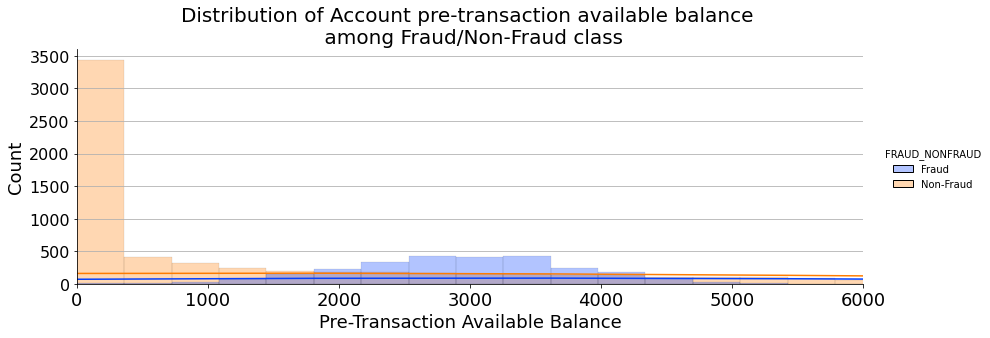

In [150]:
xcol="ACCT_PRE_TRAN_AVAIL_BAL"
xlabel="Pre-Transaction Available Balance"
title="Distribution of Account pre-transaction available balance \n among Fraud/Non-Fraud class"
savename="dist_pre_trans_blnce.png"
bins=1000
xmax=6000
displot(df, xcol, xlabel, title, savename, bins=bins, xmax=xmax)

- This plot shows us that there is a clear peak of distribution for fraudalant transaction in the range 2000-4000, compared to non-fraudalant class which peaks near $100.

- So, this feature is an important one for the model.

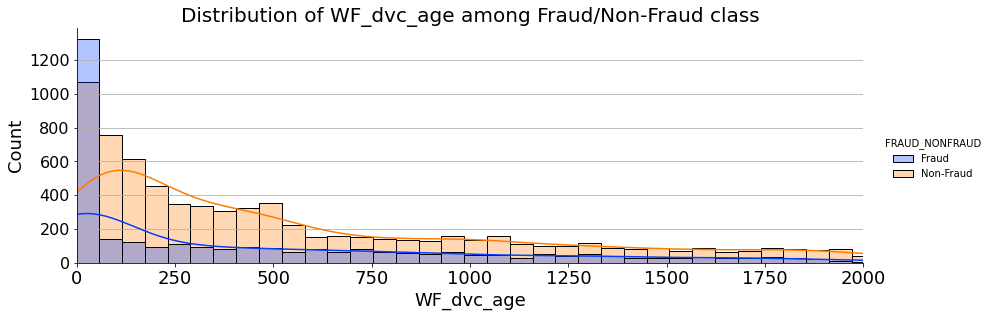

In [151]:
xcol="WF_dvc_age"
xlabel="WF_dvc_age"
title="Distribution of WF_dvc_age among Fraud/Non-Fraud class"
savename="dist_wf_dvc_age.png"
bins=50
xmax=2000
displot(df, xcol, xlabel, title, savename, bins=bins, xmax=xmax)

- Unlike the previous features, this plot doesn't tell us much about the distinction between fraud vs non-fraud class.

- So, this feature may not be greatly important but we should still keep this features as there is some distribution in the range [0,500]

## Build a model with only Numerical features

### Prepare test data before building model

In [71]:
# map Fraud to 1 and Non-Fraud to 0 in the dataframe for both train and test data
df["FRAUD_NONFRAUD"] = df["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})

In [72]:
X_train1, y_train1 = df[nume_cols], df["FRAUD_NONFRAUD"]

In [73]:
# prepare test data
df_test = df_test0.copy()
print ("missing values in test data:\n", df_test[nume_cols].isnull().sum() )
df_test["FRAUD_NONFRAUD"] = df_test["FRAUD_NONFRAUD"].map({"Fraud":1,"Non-Fraud":0})
X_test1,  y_test1  = df_test[nume_cols], df_test["FRAUD_NONFRAUD"]

missing values in test data:
 TRAN_AMT                   0
ACCT_PRE_TRAN_AVAIL_BAL    0
CUST_AGE                   0
OPEN_ACCT_CT               0
WF_dvc_age                 0
dtype: int64


In [74]:
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((11200, 5), (11200,), (2800, 5), (2800,))

### Base Model: Logistic Regression, Random Forest, XGBoost

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [83]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        
        self.model.fit(self.X_train, self.y_train)
    
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = "images/displot_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):

        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":self.model.feature_importances_})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = "images/feat_imp_"+self.savename+".png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

Accuracy = 93.68% F1 Score= 88.86% 
Precision=93.39% Recall= 84.75%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.94      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



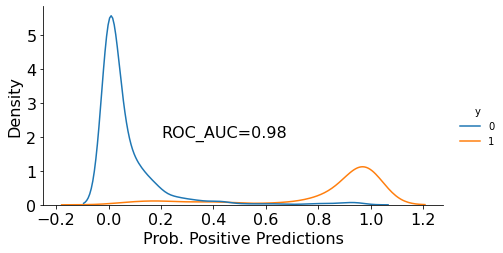

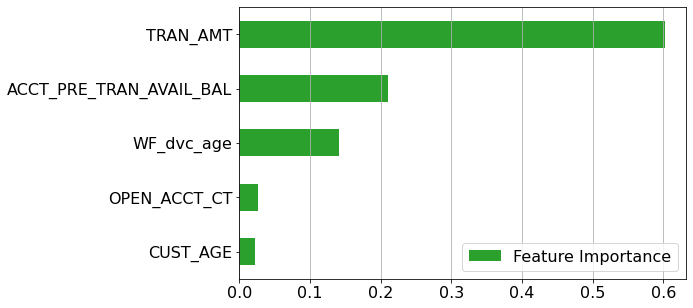

In [81]:
model_rf = RandomForestClassifier(max_depth=10,
                                  random_state=8848)

mod = Model_training(model_rf, 
                     X_train1, y_train1,
                     X_test1, y_test1,
                     "random_forest")
mod_tr, _= mod.print_metrics()
mod.displot()
mod.feature_importance()

For a base model: F1 score  ~ 88% is a great result.

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   20.6s finished


Accuracy = 93.64% F1 Score= 88.94% 
Precision=92.15% Recall= 85.95%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.92      0.86      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

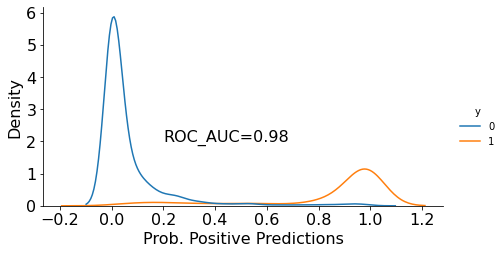

In [89]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[8, 10, 12, 14, 16]},
                           scoring ='f1',verbose=1 )

mod2 = Model_training(model_rf_gs,
                      X_train1, y_train1, X_test1, y_test1,
                      "random_forest_grid_search")
mod_tr, _= mod2.print_metrics()
mod2.displot()

In [90]:
mod_tr.best_params_

{'max_depth': 14}

Accuracy = 73.0% F1 Score= 40.85% 
Precision=58.65% Recall= 31.33%
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1967
           1       0.59      0.31      0.41       833

    accuracy                           0.73      2800
   macro avg       0.67      0.61      0.62      2800
weighted avg       0.71      0.73      0.70      2800



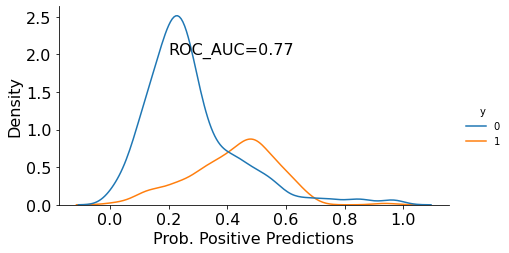

In [92]:
model_lr = LogisticRegression(max_iter=5000)

mod3 = Model_training(model_lr, X_train1, y_train1, X_test1, y_test1, "logistic_regression")
mod_tr, _= mod3.print_metrics()
mod3.displot()

Accuracy = 93.36% F1 Score= 88.49% 
Precision=91.32% Recall= 85.83%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.91      0.86      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



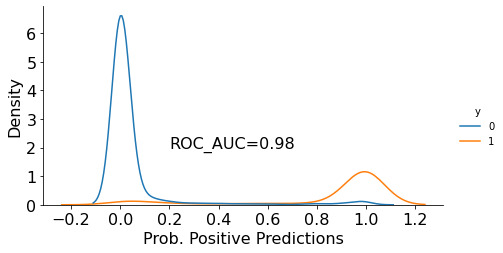

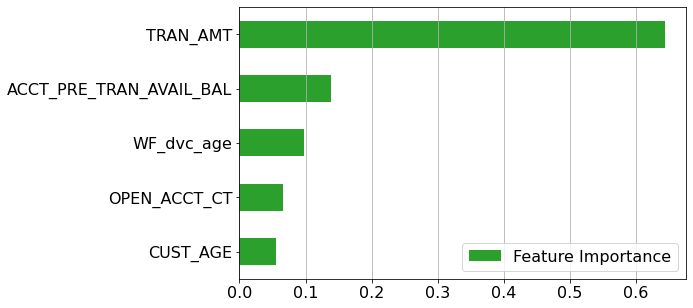

In [93]:
xgb = XGBClassifier(verbosity=1,
                    use_label_encoder=False, 
                    max_depth=10, 
                    eval_metric = "logloss")

mod4 = Model_training(xgb, X_train1, y_train1, X_test1, y_test1, "xgb")
mod_tr, _= mod4.print_metrics()
mod4.displot()
mod4.feature_importance()

Accuracy = 93.0% F1 Score= 87.89% 
Precision=90.57% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.91      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



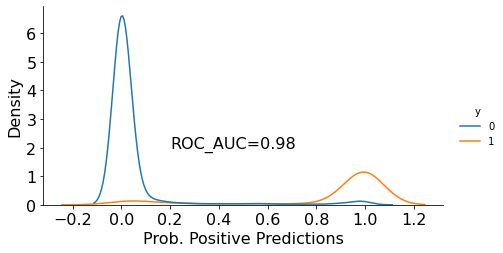

In [95]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 10, 12, 14],
                                  'eval_metric' :["logloss"]},
                      scoring = 'f1',
                      verbose = 0 )

mod5 = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1, "xgb_grid_search")
mod_tr, _= mod5.print_metrics()
mod5.displot()

In [45]:
mod_tr.best_params_

{'eval_metric': 'logloss', 'max_depth': 10}

## Deep learning models

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K

In [97]:
# this piece of code copied from 
#https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [98]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=custom_f1)
    return model

In [99]:
model_dnn = make_model_dense(X_train1, y_train1)
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [100]:
history_dnn = model_dnn.fit(X_train1, y_train1,
                            validation_data=(X_test1, y_test1),
                            epochs=20,
                            batch_size=32,
                            verbose=0)

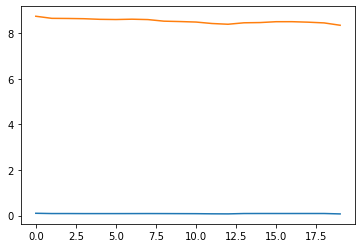

In [101]:
plt.plot(history_dnn.history['val_custom_f1'])
plt.plot(history_dnn.history['val_loss'])

## Categorical variables

In [102]:
# find # of unique features in all categorical features
for col in cate_cols:
    print (col, "\t# of Unique values:\t",df[col].nunique() )

ALERT_TRGR_CD 	# of Unique values:	 2
DVC_TYPE_TXT 	# of Unique values:	 4
AUTHC_PRIM_TYPE_CD 	# of Unique values:	 5
AUTHC_SCNDRY_STAT_TXT 	# of Unique values:	 3
CUST_STATE 	# of Unique values:	 48
CUST_SINCE_DT 	# of Unique values:	 7431
TRAN_TS 	# of Unique values:	 10871
TRAN_DT 	# of Unique values:	 333
ACTN_CD 	# of Unique values:	 1
ACTN_INTNL_TXT 	# of Unique values:	 1
TRAN_TYPE_CD 	# of Unique values:	 1
ACTVY_DT 	# of Unique values:	 333
CUST_ZIP 	# of Unique values:	 3750


In [103]:
# find # of unique features in all categorical features
d0={c:df[c].nunique() for c in cate_cols if (df[c].nunique()<=10) }
d1={c:df[c].nunique() for c in cate_cols if (df[c].nunique()>10) & (df[c].nunique()<=100) }
d2={c:df[c].nunique() for c in cate_cols if (df[c].nunique()>100) }

print ("Features with unique value in the range [1,10]:\n",d0)
print ("\nFeatures with unique value in the range [10,100]:\n",d1)
print ("\nFeatures with unique value in the range [100,10000]:\n",d2)

Features with unique value in the range [1,10]:
 {'ALERT_TRGR_CD': 2, 'DVC_TYPE_TXT': 4, 'AUTHC_PRIM_TYPE_CD': 5, 'AUTHC_SCNDRY_STAT_TXT': 3, 'ACTN_CD': 1, 'ACTN_INTNL_TXT': 1, 'TRAN_TYPE_CD': 1}

Features with unique value in the range [10,100]:
 {'CUST_STATE': 48}

Features with unique value in the range [100,10000]:
 {'CUST_SINCE_DT': 7431, 'TRAN_TS': 10871, 'TRAN_DT': 333, 'ACTVY_DT': 333, 'CUST_ZIP': 3750}


**Observations**
Broaddly we can group the categorical features into 3 categories.

**Features that have #unique values [1,10]** 
- 'ALERT_TRGR_CD'  :	 2 
- 'DVC_TYPE_TXT'  :4
- 'AUTHC_PRIM_TYPE_CD' : 5
- 'AUTHC_SCNDRY_STAT_TXT' : 3
- 'ACTN_CD'    : 1
- 'ACTN_INTNL_TXT' : 1
- 'TRAN_TYPE_CD'   : 1

We can safely delete features `ACTN_CD`, `ACTN_INTNL_TXT`,`TRAN_TYPE_CD` as they have constant value all across.

For others do some analysis on the distribution.


**Features that have #unique values [10,100]** 
- 'CUST_STATE'  48
- 'CUST_AGE'  90
- 'OPEN_ACCT_CT' 50

We can't use all of these unique values so find a way to cut these sort


**Features that have #unique values > 100** 

- 'CUST_SINCE_DT' 7431
- 'TRAN_TS' 10871
- 'TRAN_DT' 333
- 'ACTVY_DT' 333
- 'CUST_ZIP' 3750

For these the `TRAN_DT` and `ACTVY_DT` have same unique numbers so they must be same value. Remove one. For the date, it may not tell much to use all of it so may be break it up into year/month/day/time and so on.

For `CUST_ZIP` do some distribution analysis and see how it's distributed.

For `CUST_SINCE_DT` we might break up the date into year only. as month might not matter much.

For `TRAN_TS`, do more analysis as in why it's ogt so may unique values.

In [104]:
d0

{'ALERT_TRGR_CD': 2,
 'DVC_TYPE_TXT': 4,
 'AUTHC_PRIM_TYPE_CD': 5,
 'AUTHC_SCNDRY_STAT_TXT': 3,
 'ACTN_CD': 1,
 'ACTN_INTNL_TXT': 1,
 'TRAN_TYPE_CD': 1}

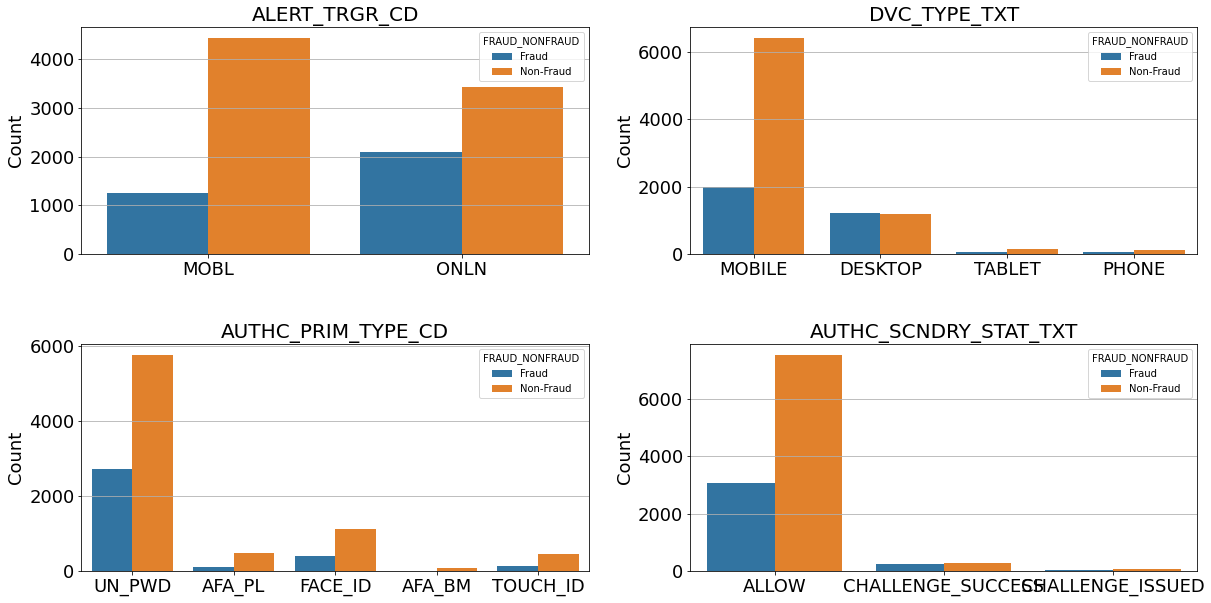

In [134]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
feats = [c for c in list(d0.keys()) if d0[c]>1]
for ic, col in enumerate(feats):
    axi=ax[ic//2, ic%2]
    sns.countplot(x=col, hue="FRAUD_NONFRAUD", data=df, ax=axi)
    axi.set_title(col, fontsize=20)
    axi.grid(axis='y')
    plt.subplots_adjust(wspace=.2, hspace=.4)
    axi.tick_params(axis='both', labelsize=18)
    
    axi.set_xlabel(None, fontsize=18);
    axi.set_ylabel("Count", fontsize=18);
figname = "images/distribution_cate_features0.png"
plt.savefig(figname, dpi=300, bbox_inches='tight')

From these plots we can drop a few more columns `DVC_TYPE_TXT`, `AUTHC_PRIM_TYPE_CD`, `AUTHC_SCNDRY_STAT_TXT` as there is a very small number of data for categories other than one particular category.

In [135]:
d1

{'CUST_STATE': 48}

In [136]:
def plot_count_plot(col, df=df ):
    
    fig, axi = plt.subplots(1,1, figsize=(20,5))
    sns.countplot(x=col, hue="FRAUD_NONFRAUD",
                  data=df, ax=axi, 
                  order = df[col].value_counts().index,
                  #order =  df[col].value_counts().sort_index(ascending=False).keys()
                  #df[xcol].value_counts().sort_index().keys()
                  #df[xcol].value_counts().sort_index(ascending=False)
                 )
    axi.set_title(col, fontsize=20)
    axi.grid(axis='y')
    plt.subplots_adjust(wspace=.2, hspace=.4)
    axi.tick_params(axis='both', labelsize=18)
    axi.set_xticklabels(labels=df[col].unique(), rotation=90)
    axi.set_xlabel(None, fontsize=18);
    axi.set_ylabel("Count", fontsize=18);
    axi.legend(loc='upper center', fontsize=18);
    figname = "images/distribution_"+col+".png"
    plt.savefig(figname, dpi=300, bbox_inches='tight')

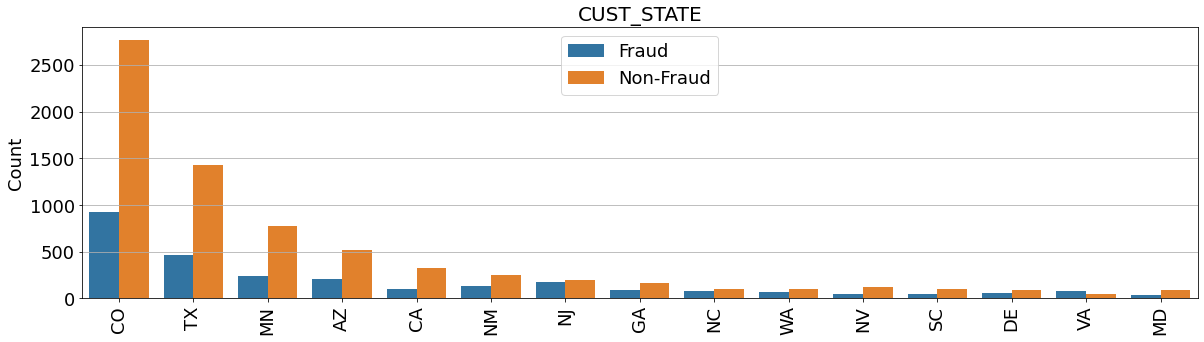

In [137]:
xcol="CUST_STATE"
plot_count_plot(xcol, df=df )
plt.xlim([-.5,14.5]);

for this feature keep only a few states: `CO`, `TX`, `MN`, `AZ` and convert rest into `OTHER`

(-0.5, 60.0)

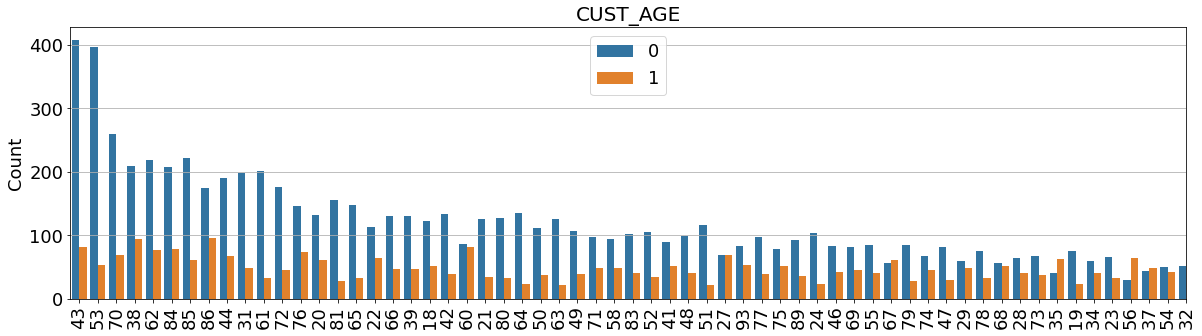

In [111]:
xcol="CUST_AGE"
plot_count_plot(xcol, df=df )
plt.xlim([-.5,60])

Since there is almost no distribution, remove this feature altogether.

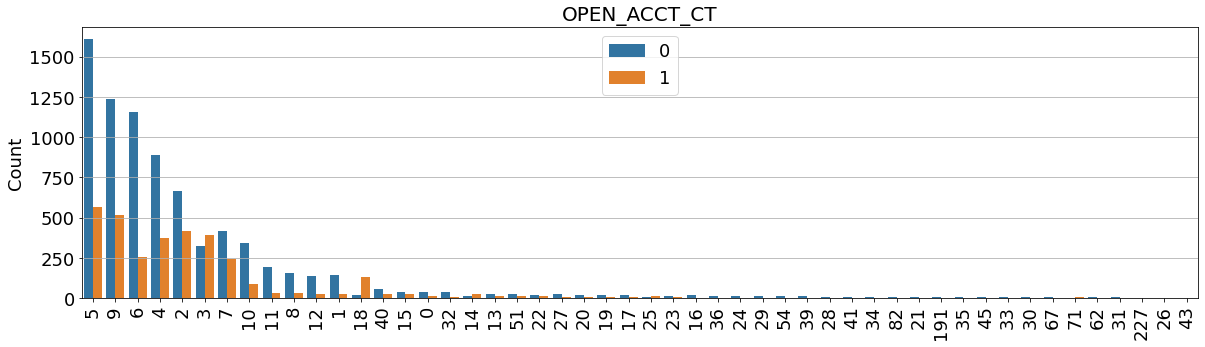

In [112]:
xcol="OPEN_ACCT_CT"
plot_count_plot(xcol, df=df )

From this keep only the [1,12] `OPEN_ACCT_CT` and convert others to `13`

In [63]:
# categories with more than 100 unique values
d2

{'CUST_SINCE_DT': 7431,
 'TRAN_TS': 10871,
 'TRAN_DT': 333,
 'ACTVY_DT': 333,
 'CUST_ZIP': 3750}

In [64]:
# check whether 'TRAN_DT' and 'ACTVY_DT' are same columns
(df['TRAN_DT']==df['ACTVY_DT']).sum()/df.shape[0]

1.0

In [65]:
from datetime import datetime

In [ ]:
df['ACTVY_DT']

In [ ]:
df['ACTVY_DT'] = pd.to_datetime(df['ACTVY_DT'].str.strip())
df['ACTVY_DT_DAY'] = df['ACTVY_DT'].apply(lambda x: x.day)
df['ACTVY_DT_MONTH'] = df['ACTVY_DT'].apply(lambda x: x.month)
df['ACTVY_DT_YEAR'] = df['ACTVY_DT'].apply(lambda x: x.year)

In [ ]:
d2

In [ ]:
df["CUST_SINCE_DT_YEAR"]=df["CUST_SINCE_DT"].apply(lambda x: x.year)
df["CUST_SINCE_DT_MONTH"] = df["CUST_SINCE_DT"].apply(lambda x: x.month)

In [ ]:
xcol="CUST_SINCE_DT_MONTH"
plot_count_plot(xcol, df=df )

In [ ]:
xcol="CUST_SINCE_DT_YEAR"
plot_count_plot(xcol, df=df )

## Data Wrangling

- Convert the categorical featurs into small number of categories when possible

In [66]:
def wrangle_column_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

In [67]:
df=wrangle_column_data(df)

In [68]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE", "OPEN_ACCT_CT"]

In [69]:
df[cate_cols_to_keep].head()

,ALERT_TRGR_CD,CUST_STATE,OPEN_ACCT_CT
2413,MOBL,CO,5
1003,MOBL,TX,5
8660,MOBL,TX,9
6349,ONLN,MN,6
1860,MOBL,AZ,4


## One Hot encoding the Categorical features

In [70]:
import category_encoders as ce

In [71]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = impute_data(df2)
df2 = wrangle_column_data(df2)

In [72]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join.values
y_train2 = df2["FRAUD_NONFRAUD"].values

In [73]:
# test data

df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] = df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = impute_data(df2_te)
df2_te = wrangle_column_data(df2_te)

In [74]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join.values
y_test2 = df2_te["FRAUD_NONFRAUD"].values

In [75]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 11), (11200,), (2800, 11), (2800,))

Accuracy = 92.89% F1 Score= 87.72% 
Precision=90.23% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



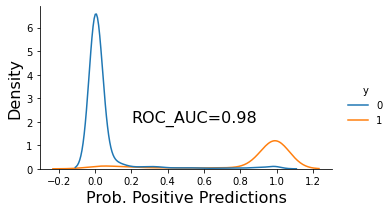

In [78]:
xgb = XGBClassifier(verbosity=1,
                    max_depth=10,
                    eval_metric = "logloss")

mod6 = Model_training(xgb, X_train2, y_train2, X_test2, y_test2)
mod_trained, _ = mod5.print_metrics()
mod6.displot()

## Different type of Encoding 
- Ordinal labeling for `OPEN_ACCT_CT` features

In [79]:
df3 = df_train0.copy()
df3["FRAUD_NONFRAUD"] = df3["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df3 = impute_data(df3)
df3 = wrangle_column_data(df3)

In [80]:
enc_cols = ["ALERT_TRGR_CD", "CUST_STATE"]
df3_num1 = pd.concat( [df3[nume_cols], df3['OPEN_ACCT_CT']], axis=1)
encoder  = ce.OneHotEncoder()
df3_cat  = encoder.fit_transform(df3[enc_cols])
df3_join = pd.concat( [df3_num1, df3_cat], axis=1)
X_train3 = df3_join
y_train3 = df3["FRAUD_NONFRAUD"]

In [81]:
df3_te = df_test0.copy()
df3_te["FRAUD_NONFRAUD"] = df3_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df3_te = impute_data(df3_te)
df3_te = wrangle_column_data(df3_te)

In [82]:
enc_cols = ["ALERT_TRGR_CD", "CUST_STATE"]
df3_te_num1 = pd.concat( [df3_te[nume_cols], df3_te['OPEN_ACCT_CT']], axis=1)
df3_te_cat  = encoder.transform(df3_te[enc_cols])
df3_te_join = pd.concat( [df3_te_num1, df3_te_cat], axis=1)
X_test3 = df3_te_join
y_test3 = df3_te["FRAUD_NONFRAUD"]

In [83]:
X_train3.shape, y_train3.shape, X_test3.shape, y_test3.shape

((11200, 11), (11200,), (2800, 11), (2800,))

In [84]:
X_train3.shape, y_train3.shape, 

((11200, 11), (11200,))

Accuracy = 93.21% F1 Score= 88.27% 
Precision=90.85% Recall= 85.83%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.91      0.86      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



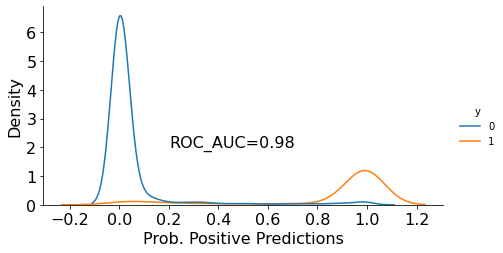

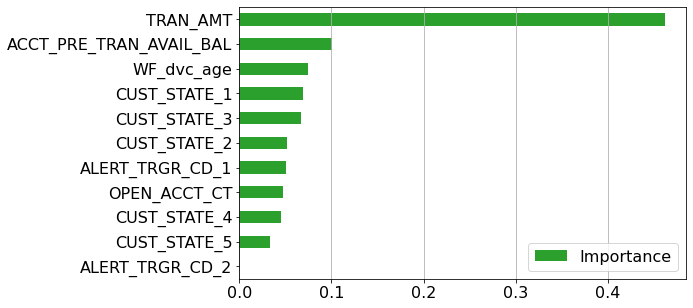

In [157]:
xgb = XGBClassifier(verbosity=1,
                    use_label_encoder=False, 
                    max_depth=10, 
                    eval_metric = "logloss")

mod7 = Model_training(xgb, X_train3, y_train3, X_test3, y_test3)
mod_trained, _ = mod7.print_metrics()
mod7.displot()
mod7.feature_importance()

Accuracy = 93.21% F1 Score= 88.21% 
Precision=91.27% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.91      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



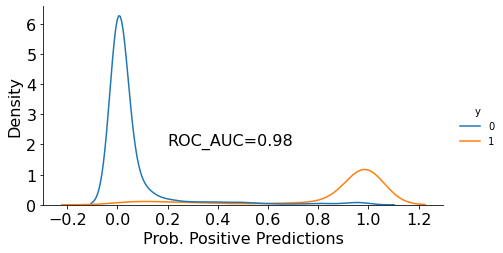

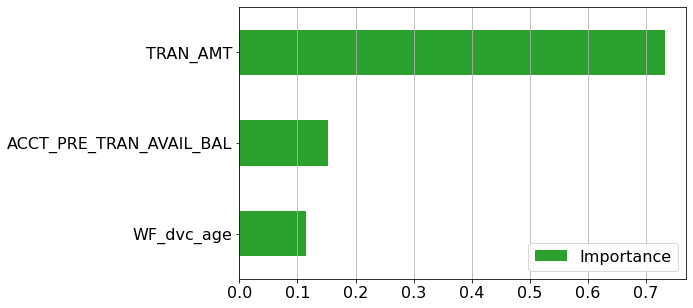

In [166]:
xgb = XGBClassifier(verbosity=1,
                    use_label_encoder=False, 
                    max_depth=10, 
                    n_estimators=40,
                    eval_metric = "logloss")

mod7 = Model_training(xgb, X_train1, y_train1, X_test1, y_test1)
mod_trained, _ = mod7.print_metrics()
mod7.displot()
mod7.feature_importance()

Accuracy = 93.21% F1 Score= 88.21% 
Precision=91.27% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.91      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



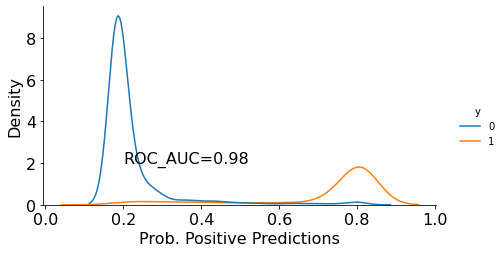

In [171]:
xgb_gs = GridSearchCV(XGBClassifier(),
                           param_grid={'max_depth':[8, 10],
                                       'n_estimators':[10,20,30],
                                       'learning_rate':[0.01, 0.02, 0.05, 0.1],
                                       'eval_metric' :["logloss"]
                                      },
                           scoring = 'f1',
                           verbose = 0 )

mod5 = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod5.print_metrics()
mod5.displot()

In [168]:
mod_tr.best_params_

{'eval_metric': 'logloss', 'max_depth': 8, 'n_estimators': 20}

In [172]:
# SVM
from sklearn.svm import SVC

Accuracy = 93.21% F1 Score= 88.21% 
Precision=91.27% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.91      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



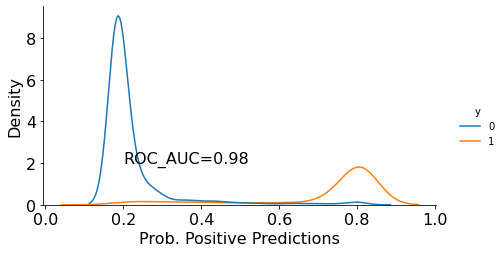

In [173]:
svm = SVC(gamma='auto')
mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [ ]:
svm_gs = GridSearchCV(SVC(),
                       param_grid={'C':[0.1, 0.5, 1.0],
                                   'kernel':['poly', 'rbf'],
                                   'gamma': ['scale', 'auto']},
                       scoring = 'f1',
                       verbose = 1 )

mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [ ]:
svm_gs = GridSearchCV(SVC(),
                       param_grid={'C':[0.1, 0.5, 1.0],
                                   'kernel':['poly', 'rbf'],
                                   'gamma': ['scale', 'auto']},
                       scoring = 'f1',
                       verbose = 1 )

mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [ ]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))
